In [2]:
# Data handling
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


In [3]:
# loading data

df = pd.concat(
    [pd.read_csv(f"data/atp_matches_{i}.csv") for i in range(2015, 2025)],
    ignore_index=True
)

df.head()


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2015-339,Brisbane,Hard,28,A,20150104,1,105357,NaN,WC,...,31.0,20.0,5.0,8.0,1.0,5.0,153.0,328.0,220.0,221.0
1,2015-339,Brisbane,Hard,28,A,20150104,2,103813,NaN,NaN,...,50.0,26.0,19.0,13.0,3.0,8.0,73.0,689.0,123.0,440.0
2,2015-339,Brisbane,Hard,28,A,20150104,3,105902,NaN,WC,...,37.0,22.0,5.0,8.0,10.0,15.0,125.0,430.0,21.0,1730.0
3,2015-339,Brisbane,Hard,28,A,20150104,4,104871,NaN,NaN,...,38.0,30.0,8.0,10.0,1.0,3.0,31.0,1195.0,72.0,691.0
4,2015-339,Brisbane,Hard,28,A,20150104,5,105373,NaN,NaN,...,62.0,40.0,19.0,15.0,4.0,8.0,34.0,1094.0,110.0,505.0


Remaining rows: 23956


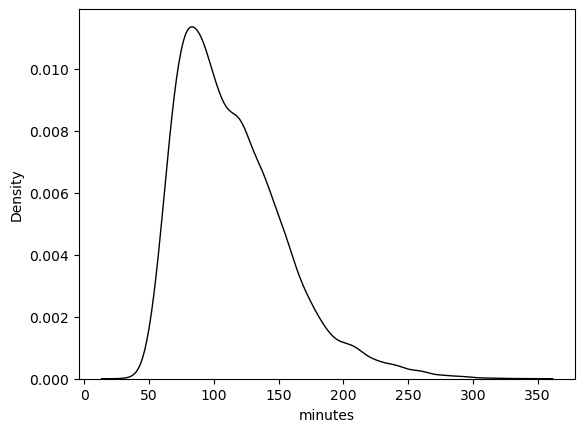

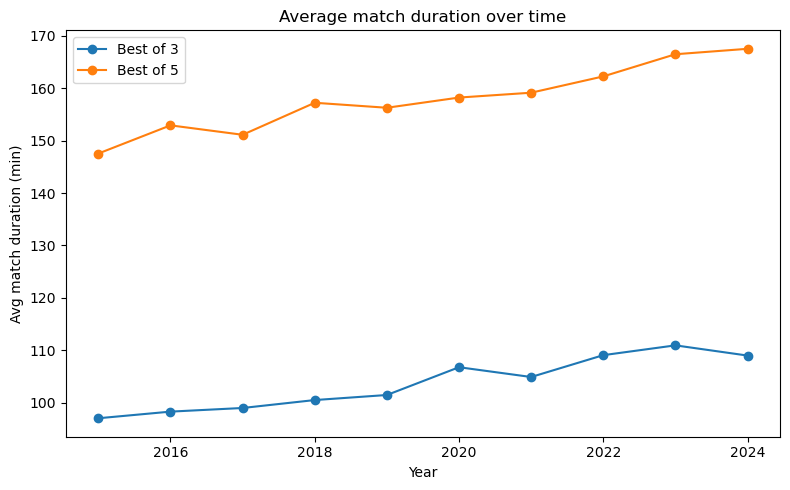

In [8]:
# Data Cleaning and Preprocessing

# we keep matches with a valid duration which is over 20 minutes
df = df[df["minutes"].notna() & (df["minutes"] > 20) & (df["minutes"] < 350)]

# we remove retirements/ walkovers/ defaults if score exists
if "score" in df.columns:
    df = df[~df["score"].str.contains("W/O|RET|DEF", na=False)]

# we cast numeric columns
numeric_cols = [
    "winner_rank", "loser_rank", "winner_age", "loser_age",
    "winner_seed", "loser_seed", "winner_ht", "loser_ht",
    "rank_diff", "age_diff", "height_diff", "seed_diff",
    "minutes", "round"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# we drop rows missing essential values
df = df.dropna(subset=["winner_rank", "loser_rank", "winner_age", "loser_age", "minutes"])

print("Remaining rows:", len(df))

sns.kdeplot(df['minutes'], linewidth=1, color='black')
plt.show()
if "year" in df.columns and "best_of" in df.columns:
    trend = df.groupby(["year", "best_of"])[target_col].mean().reset_index()

    plt.figure(figsize=(8, 5))
    for fmt, sub in trend.groupby("best_of"):
        plt.plot(sub["year"], sub[target_col], marker="o", label=f"Best of {fmt}")
    plt.xlabel("Year")
    plt.ylabel("Avg match duration (min)")
    plt.title("Average match duration over time")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
# feature engineering  

# Ranking features
df["rank_diff"] = (df["winner_rank"] - df["loser_rank"]).abs()
df["avg_rank"] = (df["winner_rank"] + df["loser_rank"]) / 2

# Age features
df["age_diff"] = (df["winner_age"] - df["loser_age"]).abs()
df["avg_age"] = (df["winner_age"] + df["loser_age"]) / 2

# Height diff (if available)
df["height_diff"] = (df["winner_ht"] - df["loser_ht"]).abs()

# Seed diff
df["seed_diff"] = (df["winner_seed"] - df["loser_seed"]).abs()

# Same country
df["same_country"] = (df["winner_ioc"] == df["loser_ioc"]).astype(int)

# Round mapping
round_map = {"R128":1, "R64":2, "R32":3, "R16":4, "QF":5, "SF":6, "F":7}
df["round"] = df["round"].map(round_map).fillna(3)

df.head()


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,winner_rank_points,loser_rank,loser_rank_points,rank_diff,avg_rank,age_diff,avg_age,height_diff,seed_diff,same_country
0,2015-339,Brisbane,Hard,28,A,20150104,1,105357,NaN,WC,...,328.0,220.0,221.0,67.0,186.5,1.8,24.60,2.0,NaN,0
1,2015-339,Brisbane,Hard,28,A,20150104,2,103813,NaN,NaN,...,689.0,123.0,440.0,50.0,98.0,11.1,27.85,5.0,NaN,0
2,2015-339,Brisbane,Hard,28,A,20150104,3,105902,NaN,WC,...,430.0,21.0,1730.0,104.0,73.0,7.1,26.45,0.0,NaN,0
3,2015-339,Brisbane,Hard,28,A,20150104,4,104871,NaN,NaN,...,1195.0,72.0,691.0,41.0,51.5,0.4,27.60,8.0,NaN,0
4,2015-339,Brisbane,Hard,28,A,20150104,5,105373,NaN,NaN,...,1094.0,110.0,505.0,76.0,72.0,8.2,29.50,8.0,NaN,0


In [6]:
# Prepareing features for modeling

# One-hot encode surface & tourney level
df = pd.get_dummies(df, columns=["surface"], prefix="surface")
df = pd.get_dummies(df, columns=["tourney_level"], prefix="tourney_level")

# Expected dummy columns
surface_cols = ["surface_Clay", "surface_Grass", "surface_Hard"]
tourney_cols = ["tourney_level_A", "tourney_level_G", "tourney_level_M"]

# we add missing columns with zeros
for col in surface_cols + tourney_cols:
    if col not in df.columns:
        df[col] = 0

# Final feature list
feature_cols = [
    "rank_diff", "avg_rank",
    "age_diff", "avg_age",
    "height_diff", "same_country",
    "round"
] + surface_cols + tourney_cols

# we fill missing values
df[feature_cols] = df[feature_cols].fillna(0)

df[feature_cols].head()


,rank_diff,avg_rank,age_diff,avg_age,height_diff,same_country,round,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_G,tourney_level_M
0,67.0,186.5,1.8,24.60,2.0,0,3.0,False,False,True,True,False,False
1,50.0,98.0,11.1,27.85,5.0,0,3.0,False,False,True,True,False,False
2,104.0,73.0,7.1,26.45,0.0,0,3.0,False,False,True,True,False,False
3,41.0,51.5,0.4,27.60,8.0,0,3.0,False,False,True,True,False,False
4,76.0,72.0,8.2,29.50,8.0,0,3.0,False,False,True,True,False,False


In [7]:
# train-test split for BO3 and BO5 matches

df3 = df[df["best_of"] == 3].copy()
df5 = df[df["best_of"] == 5].copy()

X3 = df3[feature_cols]
y3 = df3["minutes"]

X5 = df5[feature_cols]
y5 = df5["minutes"]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=42)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.25, random_state=42)

len(X3_train), len(X5_train)


(14499, 3467)

In [8]:
# now we train 4 different models and compare their performance

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, max_depth=12, min_samples_split=6, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, objective="reg:squarederror")
}

results = {}

for name, model in models.items():
    model_bo3 = model.fit(X3_train, y3_train)
    model_bo5 = model.fit(X5_train, y5_train)

    preds3 = model_bo3.predict(X3_test)
    preds5 = model_bo5.predict(X5_test)

    results[name] = {
        "BO3_R2": r2_score(y3_test, preds3),
        "BO3_RMSE": mean_squared_error(y3_test, preds3) ** 0.5,
        "BO5_R2": r2_score(y5_test, preds5),
        "BO5_RMSE": mean_squared_error(y5_test, preds5) ** 0.5,
    }

pd.DataFrame(results).T


,BO3_R2,BO3_RMSE,BO5_R2,BO5_RMSE
LinearRegression,-0.955677,45.292863,0.026264,47.493182
RandomForest,-2.020662,56.290132,0.006168,47.980755
GradientBoosting,-3.429373,68.163574,0.019017,47.669585
XGBoost,-2.897449,63.939823,-0.066169,49.696256


In [9]:
# based on performance we coose the best models for each match type 

# Best-of-3 matches --> Linear Regression
best_bo3 = LinearRegression().fit(X3_train, y3_train)

# Best-of-5 matches --> Gradient Boosting
best_bo5 = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    random_state=42
).fit(X5_train, y5_train)

print("Selected models:")
print(" - BO3 --> LinearRegression")
print(" - BO5 --> GradientBoostingRegressor")

Selected models:
 - BO3 --> LinearRegression
 - BO5 --> GradientBoostingRegressor


In [10]:
def predict_match_duration(rank1, rank2, age1, age2, surface, tourney_level, round_code, best_of):

    # we choose the correct trained model
    model = best_bo3 if best_of == 3 else best_bo5
    features = model.feature_names_in_

    # we create an empty row with all needed columns
    row = pd.DataFrame({col: [0] for col in features})

    # Ranking Features 
    row.loc[0, "rank_diff"] = abs(rank1 - rank2)
    row.loc[0, "avg_rank"]  = (rank1 + rank2) / 2

    # Age Features 
    row.loc[0, "age_diff"] = abs(age1 - age2)
    row.loc[0, "avg_age"]  = (age1 + age2) / 2

    # Round Mapping 
    round_map = {"R128":1, "R64":2, "R32":3, "R16":4, "QF":5, "SF":6, "F":7}
    row.loc[0, "round"] = round_map.get(round_code, 3)

    # Surface One-Hot
    for surf in ["Clay", "Grass", "Hard"]:
        col = "surface_" + surf
        if col in features:
            row.loc[0, col] = int(surface == surf)

    # Tournament Level One-Hot 
    for lvl in ["A", "G", "M"]:
        col = "tourney_level_" + lvl
        if col in features:
            row.loc[0, col] = int(tourney_level == lvl)

    # Predict
    pred = model.predict(row)[0]

    # Keep prediction within reasonable limits
    pred = float(np.clip(pred, 45, 240))

    print("Expected duration:", round(pred, 1), "minutes")
    return pred


In [11]:
# Example prediction

result = predict_match_duration(
    rank1=5,
    rank2=18,
    age1=27,
    age2=24,
    surface="Hard",
    tourney_level="A",
    round_code="QF",
    best_of=3
)



Expected duration: 103.2 minutes


In [12]:
# creating duration classes

def classify_duration_bo3(minutes):
    """Classification thresholds for best-of-3 matches"""
    if minutes <= 80:
        return "Short"
    elif minutes <= 120:
        return "Medium"
    else:
        return "Long"

def classify_duration_bo5(minutes):
    """Classification thresholds for best-of-5 matches"""
    if minutes <= 120:
        return "Short"
    elif minutes <= 200:
        return "Medium"
    else:
        return "Long"

# Apply classification
df_bo3 = df[df["best_of"] == 3].copy()
df_bo5 = df[df["best_of"] == 5].copy()

df_bo3["duration_class"] = df_bo3["minutes"].apply(classify_duration_bo3)
df_bo5["duration_class"] = df_bo5["minutes"].apply(classify_duration_bo5)

print("BO3 class distribution:")
print(df_bo3["duration_class"].value_counts())

print("\nBO5 class distribution:")
print(df_bo5["duration_class"].value_counts())


BO3 class distribution:
duration_class
Medium    8355
Long      5632
Short     5346
Name: count, dtype: int64

BO5 class distribution:
duration_class
Medium    2561
Short     1130
Long       932
Name: count, dtype: int64


In [13]:
# preparing data for classification models  

Xc_bo3 = df_bo3[feature_cols]
yc_bo3 = df_bo3["duration_class"]

Xc_bo5 = df_bo5[feature_cols]
yc_bo5 = df_bo5["duration_class"]

# Train/Test split
Xc3_train, Xc3_test, yc3_train, yc3_test = train_test_split(
    Xc_bo3, yc_bo3, test_size=0.25, random_state=42
)

Xc5_train, Xc5_test, yc5_train, yc5_test = train_test_split(
    Xc_bo5, yc_bo5, test_size=0.25, random_state=42
)

len(Xc3_train), len(Xc5_train)


(14499, 3467)

In [14]:
# training classification models

clf3 = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
).fit(Xc3_train, yc3_train)

clf5 = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
).fit(Xc5_train, yc5_train)

# Predictions
pred3 = clf3.predict(Xc3_test)
pred5 = clf5.predict(Xc5_test)

acc3 = accuracy_score(yc3_test, pred3)
acc5 = accuracy_score(yc5_test, pred5)

print(f"BO3 Classification Accuracy: {acc3:.3f}")
print(f"BO5 Classification Accuracy: {acc5:.3f}")


BO3 Classification Accuracy: 0.425
BO5 Classification Accuracy: 0.554


In [15]:
# confusion matrices

print("\n=== BO3 Confusion Matrix ===")
print(pd.DataFrame(
    confusion_matrix(yc3_test, pred3),
    index=["Short","Medium","Long"],
    columns=["Short","Medium","Long"]
))

print("\n=== BO5 Confusion Matrix ===")
print(pd.DataFrame(
    confusion_matrix(yc5_test, pred5),
    index=["Short","Medium","Long"],
    columns=["Short","Medium","Long"]
))



=== BO3 Confusion Matrix ===
        Short  Medium  Long
Short      42    1382    33
Medium     57    1951    51
Long       29    1228    61

=== BO5 Confusion Matrix ===
        Short  Medium  Long
Short       5     215     6
Medium      7     621    15
Long        2     270    15


In [16]:
# Match Classification Prediction (Short / Medium / Long)

def predict_match_class(rank1, rank2, age1, age2, surface, tourney_level, round_code, best_of):

    clf = clf3 if best_of == 3 else clf5
    
    features = clf.feature_names_in_
    row = pd.DataFrame({col: [0] for col in features})

    row.loc[0, "rank_diff"] = abs(rank1 - rank2)
    row.loc[0, "avg_rank"] = (rank1 + rank2) / 2
    row.loc[0, "age_diff"] = abs(age1 - age2)
    row.loc[0, "avg_age"] = (age1 + age2) / 2

    round_map = {"R128":1, "R64":2, "R32":3, "R16":4, "QF":5, "SF":6, "F":7}
    row.loc[0, "round"] = round_map.get(round_code, 3)

    for s in ["Clay","Grass","Hard"]:
        col = f"surface_{s}"
        if col in features: row.loc[0, col] = int(surface == s)

    for lvl in ["A","G","M"]:
        col = f"tourney_level_{lvl}"
        if col in features: row.loc[0, col] = int(tourney_level == lvl)

    class_pred = clf.predict(row)[0]
    class_probs = clf.predict_proba(row)[0]
    prob_dict = dict(zip(clf.classes_, np.round(class_probs, 3)))

    print(f"Predicted Duration Class: {class_pred}")
    print(f"Class Probabilities: {prob_dict}")

    return class_pred, prob_dict


In [17]:
# Example classification prediction

result = predict_match_class(
    rank1 = 5,
    rank2 = 18,
    age1 = 27,
    age2 = 24,
    surface = "Hard",
    tourney_level = "A",
    round_code = "QF",
    best_of = 3
)


Predicted Duration Class: Medium
Class Probabilities: {'Long': np.float64(0.339), 'Medium': np.float64(0.45), 'Short': np.float64(0.211)}


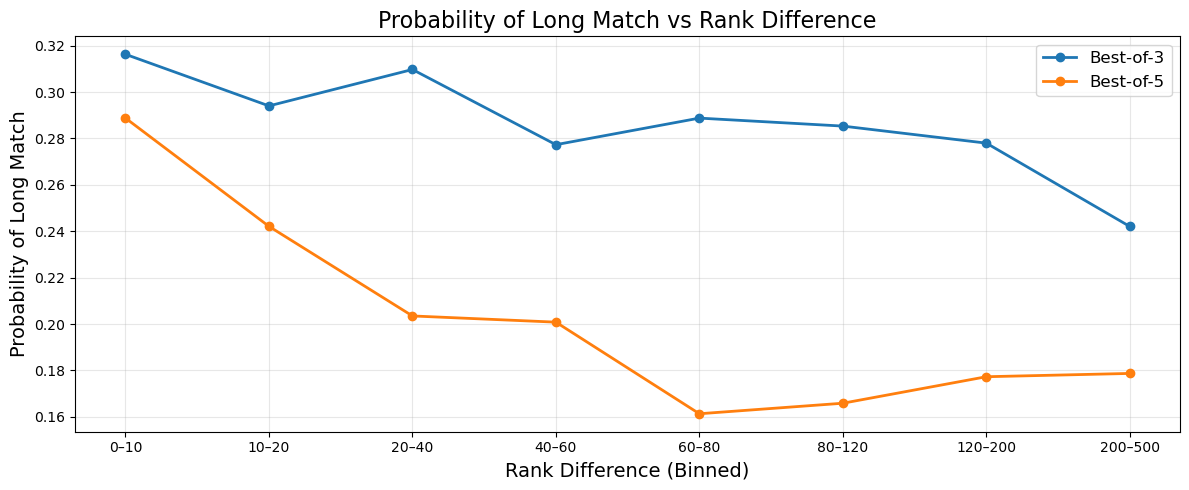

In [18]:
# Probability of Long Matches vs Rank Difference
# (Separated for Best-of-3 and Best-of-5)

# Define long match thresholds
df["is_long_bo3"] = ((df["best_of"] == 3) & (df["minutes"] > 120)).astype(int)
df["is_long_bo5"] = ((df["best_of"] == 5) & (df["minutes"] > 200)).astype(int)

# Create rank difference binning
df["rank_diff_bin"] = pd.cut(
    df["rank_diff"],
    bins=[0,10,20,40,60,80,120,200,500],
    labels=["0–10", "10–20", "20–40", "40–60", "60–80", "80–120", "120–200", "200–500"]
)

# Group by bins
bo3_probs = df[df["best_of"] == 3].groupby("rank_diff_bin")["is_long_bo3"].mean()
bo5_probs = df[df["best_of"] == 5].groupby("rank_diff_bin")["is_long_bo5"].mean()

# Plot
plt.figure(figsize=(12,5))
plt.plot(bo3_probs.index, bo3_probs.values, marker="o", label="Best-of-3", linewidth=2)
plt.plot(bo5_probs.index, bo5_probs.values, marker="o", label="Best-of-5", linewidth=2)

plt.title("Probability of Long Match vs Rank Difference", fontsize=16)
plt.xlabel("Rank Difference (Binned)", fontsize=14)
plt.ylabel("Probability of Long Match", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()



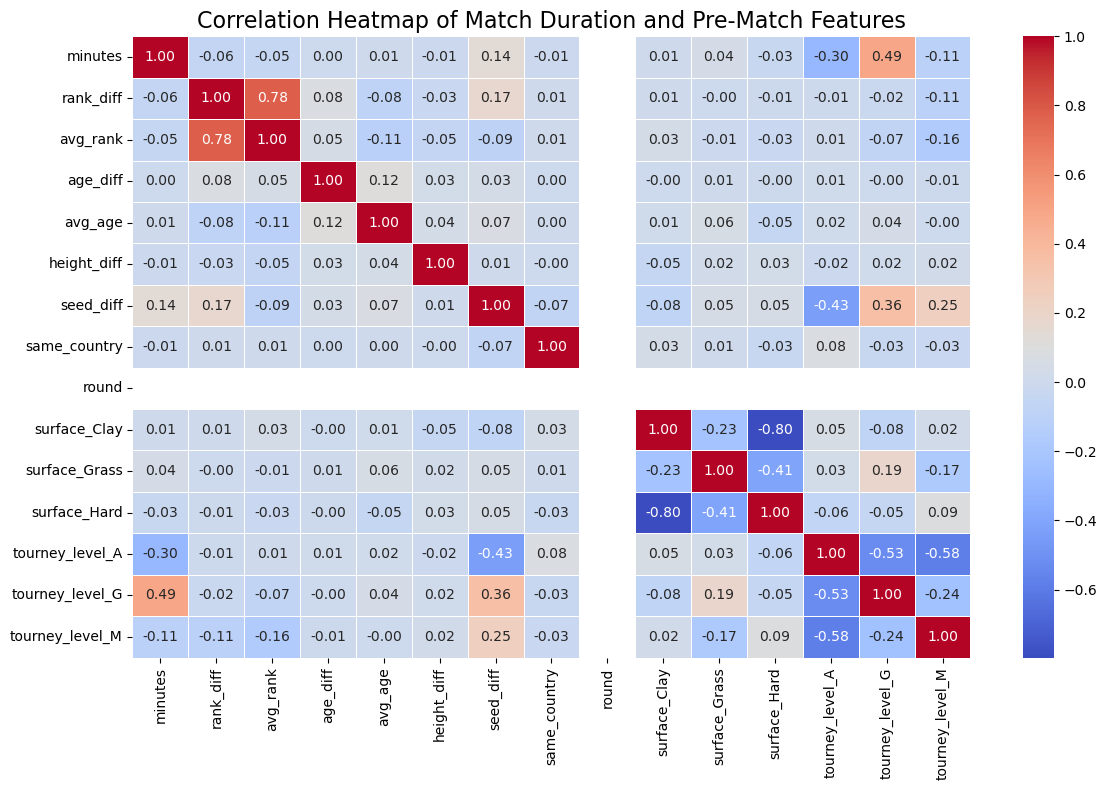

In [19]:
# ======================================
# Correlation Heatmap (Main Features)
# ======================================

import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns (model features + target)
corr_features = [
    "minutes",
    "rank_diff", "avg_rank",
    "age_diff", "avg_age",
    "height_diff",
    "seed_diff",
    "same_country",
    "round",
    "surface_Clay", "surface_Grass", "surface_Hard",
    "tourney_level_A", "tourney_level_G", "tourney_level_M"
]

# Filter existing columns only (avoid KeyErrors)
corr_features = [c for c in corr_features if c in df.columns]

# Compute correlation matrix
corr_matrix = df[corr_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="coolwarm", 
    linewidths=0.5, 
    fmt=".2f"
)

plt.title("Correlation Heatmap of Match Duration and Pre-Match Features", fontsize=16)
plt.tight_layout()
plt.show()
